In [1]:
# Import libraries
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import math
import qrcode
import os

In [2]:
# Takes a numpy array and displays the image with no axes using Matplotlib.
def display_image(image, figsize = (5, 7)):
    fig, ax = plt.subplots(1, 1, figsize = figsize)
    plt.imshow(image)
    ax.set_axis_off()
    
    return

In [3]:
# Creates a blank numpy array of the specified dimensions, with a prefilled value and encoding
def create_blank_image(resolution = (3288, 4488, 3), background_color = 34, encoding = np.uint8):
    return np.full(resolution, background_color, encoding)

In [4]:
# Draws a line on an image with openCV, using a more intuitive start_x, end_x, start_y, end_y ordering
def place_line(image, x_1, x_2, y_1, y_2, color = (255, 255, 255), line_width = 5):
    cv2.line(image, (x_1, y_1), (x_2, y_2), color, line_width)
    
    return

In [5]:
# Displays margins on an image given horizontal and vertical margin specifications
def show_margins(image, x_margin, y_margin, x_color = (0, 255, 255), y_color = (255, 255, 0)):
    # Y margins
    place_line(image, x_margin, image.shape[1] - x_margin, y_margin, y_margin, y_color)
    place_line(image, x_margin, image.shape[1] - x_margin,
               image.shape[0] - y_margin, image.shape[0] - y_margin, y_color)
    
    # # X margins
    place_line(image, x_margin, x_margin, y_margin, image.shape[0] - y_margin, x_color)
    place_line(image, image.shape[1] - x_margin, image.shape[1] - x_margin,
               y_margin, image.shape[0] - y_margin, x_color)
    
    return

In [6]:
class TextBox:
    
    def __init__(self, name, text, font, font_scale, font_width, font_color,
                 left_margin, right_margin, line_spacing,
                 paragraph_break = False, circle = True, circle_size = 25, paragraph_spacing = 1.5,
                 bold_words = [], delim = ' ', splitter = ''):
        # Required attributes
        self.name = name
        self.text = text
        self.font = font
        self.font_scale = font_scale
        self.font_width = font_width
        self.font_color = font_color
        self.line_spacing = line_spacing
        self.left_margin = left_margin
        self.right_margin = right_margin
        
        # Optional attributes
        self.paragraph_break = paragraph_break
        self.circle = circle
        self.circle_size = circle_size
        self.paragraph_spacing = paragraph_spacing
        self.bold_words = bold_words
        self.delim = delim
        self.splitter = splitter
        
        # Calculated attributes
        self.line_height = 0
        self.height = 0
        self.width = 0
        self.bounding_box = (0, 0)
        self.paragraphs = []

    # Calculates the bounding box as well as creates paragraphs and lines for pasting
    def calculate_text_bb(self, image, max_bb_size, min_font_scale):       
        # Generate generic size of space character to use for line height
        space_size = cv2.getTextSize(' ', self.font, self.font_scale, self.font_width)[0]
        self.line_height = space_size[1]
        # Save the original left margin to use if needed for recursion
        original_left_margin = self.left_margin

        # Shift the left margin over if there are multiple paragraphs due to bullet points
        if self.paragraph_break:
            self.left_margin = self.left_margin + self.circle_size + space_size[0]

        current_X = self.left_margin

        # Split paragraphs
        if self.paragraph_break:
            paragraphs_raw = self.text.split('\p')
        else:
            paragraphs_raw = [self.text]

        # Calculate lines for later writing to image
        paragraphs_text = []

        for paragraph_raw in paragraphs_raw:
            full_text = ''
            text_list = paragraph_raw.split(self.delim)
            current_X = self.left_margin
            
            for ix, word in enumerate(text_list):
                word = word.lstrip()
                
                # If the word is not the first, put in a leading space.
                # If the delim is not a space and the word is not the last, also add the splitter.
                if ix != 0:
                    word = ' ' + word
                if ix != len(text_list) - 1 and self.delim != ' ':
                    word += self.splitter

                # Calculate word length, then check if it goes beyond the maximum horizonal length.
                # If below maximum length, add the word and update X.
                # Else, add a newline character, remove the leading space, and update X.
                word_size = cv2.getTextSize(word, self.font, self.font_scale, self.font_width)[0]

                if (current_X + word_size[0]) <= (image.shape[1] - self.right_margin):
                    full_text += word
                    current_X += word_size[0]
                else:
                    full_text += '\n' + word[1:]           
                    current_X = self.left_margin + cv2.getTextSize(word[1:], self.font,
                                                                   self.font_scale,
                                                                   self.font_width)[0][0]

            paragraphs_text.append(full_text)

        # Create list of paragraphs containing lists of lines.
        self.paragraphs = [paragraph.split('\n') for paragraph in paragraphs_text]

        # Calculate the width and height of the paragraphs.
        for i, paragraph in enumerate(self.paragraphs):
            if i != 0:
                self.height += int(space_size[1] * (self.paragraph_spacing * self.line_spacing))

            for j, line in enumerate(paragraph):
                line_size = cv2.getTextSize(line, self.font, self.font_scale, self.font_width)[0]
                self.height += line_size[1]

                if j != (len(paragraph) - 1):
                    self.height += int(space_size[1] * self.line_spacing)

                if line_size[0] > self.width:
                    self.width = line_size[0]
        
        # Create bounding box based on calculated width and height.
        self.bounding_box = (self.width + 100, self.height + 80)
        
        # If the font scale is at the minimum font scale, end calculations.
        if self.font_scale == min_font_scale:
            print(f'Reached minimum font scale for {self.name}.')
            return
        
        # If the calculated bounding box is too large, downscale the font scale and font width
        # then recalculate using the new attributes. Else, end calculations.
        if self.bounding_box[1] > max_bb_size:
            self.font_scale -= 0.5
            print(f'Exceeded maximum bounding box for {self.name}. Recalculating with font scale {self.font_scale}')
            self.font_width = math.ceil(self.font_scale * 3)
            self.left_margin = original_left_margin
            self.height = 0
            self.width = 0
            self.calculate_text_bb(image, max_bb_size, min_font_scale)
            
        return

    # Places the text on an image at a given x, y location with possible centering and bolding of words.
    def place_text(self, image, x, y, bottom_left_origin = False, centered = False, bold = False):
        # If there are multiple paragraphs, calculate generic bounding box for creating paragraph spacing.
        if self.paragraph_break:
            space_size = cv2.getTextSize(' ', self.font, self.font_scale,
                                               self.font_width)[0]

        current_Y = y + int((self.bounding_box[1] - self.height) / 2)

        # Place each paragraph on the image
        for i, paragraph in enumerate(self.paragraphs):
            # If not the first paragraph, add some paragraph spacing
            if i != 0:
                current_Y += int((1 + (self.paragraph_spacing * self.line_spacing)) * space_size[1])

            # If multiple paragraphs, add a bullet point
            if self.paragraph_break and self.circle:
                cv2.circle(image, (x, current_Y - int(space_size[1] / 2)), self.circle_size,
                               color = self.font_color, thickness = -1)
                x_left = x + self.circle_size + space_size[0]
            else:
                x_left = x

            # If words need to be bolded, add bold markers to required phrases
            if bold:
                for phrase in self.bold_words:
                    phrase_split = '\n*'.join(phrase.split(' '))
                    paragraph = re.sub(phrase, '~' + ' ~'.join(phrase.split(' ')),
                                       '\n'.join(paragraph)).split('\n')
                    paragraph = re.sub(phrase_split, '~' + '~'.join(phrase_split.split('*')),
                                       '\n'.join(paragraph)).split('\n')

            # Place each line in the paragraph on the image
            for j, line in enumerate(paragraph):
                # If centered, calculated centered coordinates
                if centered:
                    line_size = cv2.getTextSize(line, self.font, self.font_scale,
                                                self.font_width)[0]
                    current_X = int((image.shape[1] - line_size[0]) / 2)
                else:
                    current_X = x_left

                # Place each word in the line on the image
                for k, word in enumerate(line.split(' ')):
                    # If bolded, check for bold markers and adjust
                    if bold and re.search(r'~\w+|\w+~', word) is not None:
                        word = re.sub(r'~', '', word)
                        font_color = (255, 255, 255)
                    else:
                        font_color = self.font_color

                    # If not the first word on the line, prepend with a space
                    if k != 0:
                        word = ' ' + word
                    word_size = cv2.getTextSize(word, self.font, self.font_scale,
                                             self.font_width)[0]
                    cv2.putText(image, word, (current_X, current_Y), self.font, self.font_scale,
                                font_color, self.font_width, cv2.LINE_AA, bottomLeftOrigin = bottom_left_origin);

                    current_X += word_size[0]            

                # If not the last line in the paragraph, add line spacing
                if j != len(paragraph) - 1:
                    current_Y += int(word_size[1] * (1 + self.line_spacing))

        return y + self.bounding_box[1]

In [7]:
# Places a qr code on the image given x, y coordinates and padding
def place_qr(image, qr, x, y, padding = 200):
    
    qr_x_coord = (x, x + qr.shape[1])
    qr_y_coord = (y + int(padding / 2), y + int(padding / 2) + qr.shape[0])
    
    image[qr_y_coord[0]:qr_y_coord[1],qr_x_coord[0]:qr_x_coord[1],:] = qr
    
    return qr_x_coord[1], qr_y_coord[1]

In [8]:
# Calculate the total vertical space used by various text boxes and line spacing.
def calculate_vertical_space(text_boxes, qr_height = 0, top_margin = 450, bot_margin = 400,
                         line_break_spacing = 35, num_line_breaks = 3, padding = 0):

    # Add the top and bottom margins, a QR height, line break spacing, and padding
    vertical_space = top_margin + bot_margin + (num_line_breaks * line_break_spacing)\
                        + qr_height + padding
    
    # For each text box, add the bounding box height and the line height
    for text_box in text_boxes:
        vertical_space += text_box.bounding_box[1] + text_box.line_height
    
    return vertical_space

In [9]:
# Checks if the entry is a valid floating point number, including a decimal point
def check_valid_float(x, alt_value):
    if not np.isnan(x) and re.match(r'^\d+.?\d*$', str(x)) is not None:
        return float(x)
    else:
        return alt_value

In [10]:
# Checks if the entry is an integer
def check_valid_int(x, alt_value):
    if not np.isnan(x) and re.match(r'^\d+$', str(x)) is not None:
        return int(x)
    else:
        return alt_value

In [11]:
# Checks if the entry is a valid name and cleans the name
def check_valid_name(x):
    if type(x.image_name) == float and np.isnan(x.image_name):
        return f'image_{int(x.name) + 1:02d}'
    return re.sub('[.#<\$+%>!`&*\'\"|\{\}\?=\/\:\\\@, ]', '_', str(x.image_name.lower().strip('\" .-_')))

In [12]:
# Checks if the entry is a nan value
def check_valid_string(x):
    if type(x) == float and np.isnan(x):
        return ''
    else:
        return str(x)

In [13]:
# Validates entries in a dataframe that has been loaded from a csv
def validate_parameters(df):
    # Name check
    df.image_name = df.apply(lambda x: check_valid_name(x), axis = 1)
    
    # Section check
    df.title_text = df.title_text.apply(lambda x: check_valid_string(x))
    df.points_text = df.points_text.apply(lambda x: check_valid_string(x))
    df.summary_text = df.summary_text.apply(lambda x: check_valid_string(x))
    df.back_title_text = df.back_title_text.apply(lambda x: check_valid_string(x))
    df.back_body_text = df.back_body_text.apply(lambda x: check_valid_string(x))
    
    # Font scale check
    df.title_font_scale = df.title_font_scale.apply(lambda x: check_valid_float(x, 6.0))
    df.points_font_scale = df.points_font_scale.apply(lambda x: check_valid_float(x, 5.0))
    df.summary_font_scale = df.summary_font_scale.apply(lambda x: check_valid_float(x, 3.5))
    df.back_title_font_scale = df.back_title_font_scale.apply(lambda x: check_valid_float(x, 6.0))
    df.back_body_font_scale = df.back_body_font_scale.apply(lambda x: check_valid_float(x, 3.5))
    
    # Font color check
    df.title_font_color = df.title_font_color.apply(lambda x: check_valid_int(x, 255))
    df.points_font_color = df.points_font_color.apply(lambda x: check_valid_int(x, 220))
    df.summary_font_color = df.summary_font_color.apply(lambda x: check_valid_int(x, 180))
    df.back_title_font_color = df.back_title_font_color.apply(lambda x: check_valid_int(x, 255))
    df.back_body_font_color = df.back_body_font_color.apply(lambda x: check_valid_int(x, 180))

    # Line spacing check
    df.title_line_spacing = df.title_line_spacing.apply(lambda x: check_valid_float(x, 1.2))
    df.points_line_spacing = df.points_line_spacing.apply(lambda x: check_valid_float(x, 1.2))
    df.summary_line_spacing = df.summary_line_spacing.apply(lambda x: check_valid_float(x, 1.2))
    df.back_title_line_spacing = df.back_title_line_spacing.apply(lambda x: check_valid_float(x, 1.2))
    df.back_body_line_spacing = df.back_body_line_spacing.apply(lambda x: check_valid_float(x, 1.1))

    # Margin check
    df.top_margin = df.top_margin.apply(lambda x: check_valid_int(x, 400))
    df.bot_margin = df.bot_margin.apply(lambda x: check_valid_int(x, 400))
    df.left_margin = df.left_margin.apply(lambda x: check_valid_int(x, 400))
    df.right_margin = df.right_margin.apply(lambda x: check_valid_int(x, 400))
    
    # QR size, QR offset, line break spacing, bullet points, qr url, bold words, paragraph_spacing check
    df.qr_url = df.qr_url.apply(lambda x: check_valid_string(x))
    df.qr_size = df.qr_size.apply(lambda x: check_valid_int(x, 600))
    df.qr_offset = df.qr_offset.apply(lambda x: check_valid_int(x, 75))
    df.line_break_spacing = df.line_break_spacing.apply(lambda x: check_valid_int(x, 35))
    df.bullet_points = df.bullet_points.apply(lambda x: int(x) if x == 1 or x == 0 else 1)
    df.bold_words = df.bold_words.apply(lambda x: check_valid_string(x))
    df.paragraph_spacing = df.paragraph_spacing.apply(lambda x: check_valid_float(x, 1.5))
    
    return

In [14]:
# Creates an image based off of a row/series from a dataframe
def create_image(series, display = False, margins = False, save = True):
    print(f"Calculating bounding boxes for {series.image_name}.")
    
    # Set font and font widths
    font = cv2.FONT_HERSHEY_SIMPLEX
    title_font_width = math.ceil(series.title_font_scale * 3)
    points_font_width = math.ceil(series.points_font_scale * 3)
    summary_font_width = math.ceil(series.summary_font_scale * 3)
    back_title_font_width = math.ceil(series.back_title_font_scale * 3)
    back_body_font_width = math.ceil(series.back_body_font_scale * 3)
    
    # Set font color
    title_font_color = (int(series.title_font_color),) * 3
    points_font_color = (int(series.points_font_color),) * 3
    summary_font_color = (int(series.summary_font_color),) * 3
    back_title_font_color = (int(series.back_title_font_color),) * 3
    back_body_font_color = (int(series.back_body_font_color),) * 3
    
    # Set qr size
    qr_size = (series.qr_size,) * 2
    
    # Parse bold words list
    bold_words = series.bold_words.split(';')
    
    # Set bullet points and paragraph spacing
    circle = series.bullet_points
    paragraph_spacing = series.paragraph_spacing
    
    # Create blank front and back images
    image_front = create_blank_image()
    image_back = create_blank_image()
    
    # Calculate front image bounding boxes
    summary_text = TextBox(
        "Summary Text",
        series.summary_text,
        font,
        series.summary_font_scale,
        summary_font_width,
        summary_font_color,
        series.left_margin,
        series.right_margin,
        series.summary_line_spacing,
        bold_words = bold_words,
    )
    summary_text.calculate_text_bb(image_front, 1000, 2.5)
    
    # Create QR code, save to images, and resize
    qr_image = np.asarray(qrcode.make(series.qr_url).convert("RGB"), dtype = np.uint8)
    if save:
        cv2.imwrite(f'images/{series.image_name}_qr.png', qr_image)
    qr_image = cv2.resize(qr_image, qr_size)

    qr_text = TextBox(
        "QR Text",
        "Scan the QR code on the right to see the full deck list on Moxfield. For more information, see the other side of this card.",
        font,
        summary_text.font_scale,
        summary_text.font_width,
        summary_text.font_color,
        series.left_margin,
        series.right_margin + series.qr_offset + qr_image.shape[1],
        series.summary_line_spacing
    )
    qr_text.calculate_text_bb(image_front, 500, summary_text.font_scale)

    # Need to calculate the prefix width first in order to get left margin for points text
    points_prefix = TextBox(
        "Points Prefix",
        "Points: ",
        font,
        series.points_font_scale,
        points_font_width,
        points_font_color,
        series.left_margin,
        series.right_margin,
        series.points_line_spacing
    )
    points_prefix.calculate_text_bb(image_front, 200, summary_text.font_scale + 0.5)

    points_text = TextBox(
        "Points Text",
        series.points_text,
        font,
        series.points_font_scale,
        points_font_width,
        points_font_color,
        series.left_margin + points_prefix.width,
        series.right_margin,
        series.points_line_spacing,
        delim = ';',
        splitter = ','
    )
    points_text.calculate_text_bb(image_front, 600, summary_text.font_scale + 0.5)

    # If the points text is smaller than the points prefix, rescale and recalculate
    if(points_text.font_scale < points_prefix.font_scale):
        points_prefix.font_scale = points_text.font_scale
        points_prefix.font_width = points_text.font_width
        points_prefix.calculate_text_bb(image_front, 200, points_text.font_scale)
        points_text.left_margin = series.left_margin + points_prefix.width
        points_text.calculate_text_bb(image_front, 600, points_text.font_scale)
    
    title_text = TextBox(
        "Front Title",
        series.title_text,
        font,
        series.title_font_scale,
        title_font_width,
        title_font_color,
        series.left_margin,
        series.right_margin,
        series.title_line_spacing
    )
    title_text.calculate_text_bb(image_front, 280, points_text.font_scale + 0.5)
    
    # Calculate back image bounding boxes
    back_text = TextBox(
        "Back Body Text",
        series.back_body_text,
        font,
        series.back_body_font_scale,
        back_body_font_width,
        back_body_font_color,
        series.left_margin,
        series.right_margin,
        series.back_body_line_spacing,
        bold_words = bold_words,
        paragraph_break = True,
        circle = circle,
        paragraph_spacing = paragraph_spacing
    )
    back_text.calculate_text_bb(image_back, 2400, 2.5)

    back_title_text = TextBox(
        "Back Title Text",
        series.back_title_text,
        font,
        series.back_title_font_scale,
        back_title_font_width,
        back_title_font_color,
        series.left_margin,
        series.right_margin,
        series.back_title_line_spacing
    )
    back_title_text.calculate_text_bb(image_back, 280, back_text.font_scale + 1)
    
    # Calculate total vertical space used for all bounding boxes
    front_vertical_space = calculate_vertical_space([title_text, points_text, summary_text],
                                                qr_height = qr_image.shape[0],
                                                top_margin = series.top_margin, bot_margin = series.bot_margin,
                                                line_break_spacing = series.line_break_spacing, num_line_breaks = 2,
                                                padding = 100)

    back_vertical_space = calculate_vertical_space([back_title_text],
                                               padding = int(back_text.line_height + back_text.height),
                                               top_margin = series.top_margin, bot_margin = series.bot_margin,
                                               line_break_spacing = series.line_break_spacing, num_line_breaks = 1)

    # Write text to front image
    if (image_front.shape[0] - front_vertical_space) >= 0:
        # Calculate y-positions
        title_text_Y = series.top_margin + title_text.line_height
        title_points_line_Y = title_text_Y + title_text.bounding_box[1] - series.line_break_spacing
        points_text_Y = title_points_line_Y + (2 * series.line_break_spacing) + points_text.line_height
        summary_text_Y = points_text_Y + points_text.bounding_box[1] + summary_text.line_height
        summary_qr_line_Y = summary_text_Y + summary_text.bounding_box[1] + series.line_break_spacing
        
        # Write text and line breaks to front image
        title_Y = title_text.place_text(image_front, series.left_margin, title_text_Y, centered = True)
        place_line(image_front, series.left_margin - 50, image_front.shape[1] - series.right_margin + 50,
                   title_points_line_Y, title_points_line_Y)
        points_prefix_Y = points_prefix.place_text(image_front, series.left_margin, points_text_Y)
        points_Y = points_text.place_text(image_front, series.left_margin + points_prefix.width, points_text_Y)
        summary_Y = summary_text.place_text(image_front, series.left_margin, summary_text_Y, bold = True)
        place_line(image_front, series.left_margin - 50, image_front.shape[1] - series.right_margin + 50,
                   summary_qr_line_Y, summary_qr_line_Y)
        qr_coords = place_qr(image_front, qr_image, 
                             image_front.shape[1] - series.right_margin - qr_image.shape[1],
                             summary_qr_line_Y)
        qr_Y = qr_text.place_text(image_front, series.left_margin, qr_coords[1] - qr_text.bounding_box[1]\
                                  + int((qr_text.bounding_box[1] - qr_text.height) / 2))
    else:
        print(f"Front text uses too much vertical space for {series.image_name}.")

    # Write text to back image
    if (image_back.shape[0] - back_vertical_space) >= 0:
        # Calculate y-positions
        back_title_text_Y = series.top_margin + back_title_text.line_height
        back_title_body_line_Y = back_title_text_Y + back_title_text.bounding_box[1] - series.line_break_spacing
        back_body_text_Y = back_title_body_line_Y + (2 * series.line_break_spacing) + back_text.line_height
        
        # Write text and line breaks to back image
        back_title_Y = back_title_text.place_text(image_back, series.left_margin, back_title_text_Y, centered = True)
        place_line(image_back, series.left_margin - 50, image_front.shape[1] - series.right_margin + 50,
                   back_title_body_line_Y, back_title_body_line_Y)
        back_text_Y = back_text.place_text(image_back, series.left_margin, back_body_text_Y, bold = True)
    else:
        print("Back text uses too much vertical space.")

    # Add margins to images
    if margins:
        show_margins(image_front, series.left_margin - 50, series.top_margin - 50)
        show_margins(image_back, series.left_margin - 50, series.top_margin - 50)

    # Display images
    if display:
        display_image(image_front)
        display_image(image_back)
    
    # Save images
    if save:
        cv2.imwrite(f'images/{series.image_name}_front.png', image_front)
        cv2.imwrite(f'images/{series.image_name}_back.png', image_back)
        
    text_boxes = [title_text, points_prefix, points_text, summary_text, qr_text, back_title_text, back_text]
        
    return (image_front, image_back), text_boxes

In [15]:
def main(csv = 'config.csv', margins = False, display = True, save = True):
    # Check if config file exists
    if not os.path.exists(csv):
        print(f'{csv} not found, please ensure {csv} exists in the same directory as this program and run again.')
        return
    
    # Read in config file
    df = pd.read_csv(csv, index_col = False)
    
    # Drop bad columns
    for column in df.columns:
        if re.match('Unnamed: \d+', column) is not None:
            df.drop(column, axis = 1, inplace = True)
    
    # Validate entries
    validate_parameters(df)
    
    # Check if images folder exists, create it if it does not
    if not os.path.isdir('images'):
        print('Images folder does not exist, creating images folder.')
        os.mkdir('images')
    
    # Process images
    images = []
    
    for i in df.index:
        print(f'Processing {df.iloc[i].image_name}.')
        image_pair = create_image(df.iloc[i], margins = margins, display = display, save = save)
        images.append(image_pair)
        
    print(f'{len(df.index)} images processed.')
    
    return images

In [16]:
images = main(csv = 'config-test.csv', display = False, save = False)

Processing uw_vault.
Calculating bounding boxes for uw_vault.
Reached minimum font scale for QR Text.
Processing 4c_spellseeker.
Calculating bounding boxes for 4c_spellseeker.
Reached minimum font scale for QR Text.
Processing abcde______________________edcba.
Calculating bounding boxes for abcde______________________edcba.
Reached minimum font scale for QR Text.
Processing uw_vault_4c_spellseeker.
Calculating bounding boxes for uw_vault_4c_spellseeker.
Reached minimum font scale for QR Text.
Exceeded maximum bounding box for Front Title. Recalculating with font scale 5.5
Reached minimum font scale for Front Title.
Exceeded maximum bounding box for Back Title Text. Recalculating with font scale 5.5
Exceeded maximum bounding box for Back Title Text. Recalculating with font scale 5.0
Exceeded maximum bounding box for Back Title Text. Recalculating with font scale 4.5
Reached minimum font scale for Back Title Text.
4 images processed.


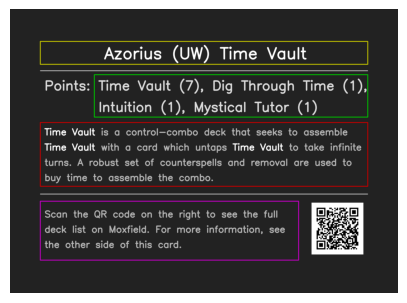

In [17]:
# Required Parameters - Front Image
image_front = images[0][0][0].copy()
text_boxes = images[0][1].copy()

# Title text
cv2.rectangle(image_front,
              (350, 375),
              (image_front.shape[1] - 350,
               425 + text_boxes[0].bounding_box[1]),
              (192, 192, 0), 10);

# Points text
cv2.rectangle(image_front,
              (350 + text_boxes[1].width, 375 + 35 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]),
              (image_front.shape[1] - 350,
               425 + 35 + text_boxes[0].line_height + text_boxes[0].bounding_box[1] + text_boxes[2].bounding_box[1]),
              (0, 192, 0), 10);

# Summary text
cv2.rectangle(image_front,
              (350, 375 + 35 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
               + text_boxes[2].line_height + text_boxes[2].bounding_box[1]),
              (image_front.shape[1] - 350,
               425 + 35 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
               + text_boxes[2].line_height + text_boxes[2].bounding_box[1] + text_boxes[3].bounding_box[1]),
              (192, 0, 0), 10);

# QR text
cv2.rectangle(image_front,
              (350, 375 + 70 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
               + text_boxes[2].line_height + text_boxes[2].bounding_box[1]\
               + text_boxes[3].line_height + text_boxes[3].bounding_box[1]\
               + 700 - text_boxes[4].bounding_box[1] - text_boxes[4].line_height),
              (image_front.shape[1] - 475 - 675,
               425 + 70 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
               + text_boxes[2].line_height + text_boxes[2].bounding_box[1]\
               + text_boxes[3].line_height + text_boxes[3].bounding_box[1]\
               + 700 + int((text_boxes[4].bounding_box[1] - text_boxes[4].height) / 2)),
              (192, 0, 192), 10);

display_image(image_front)

# cv2.imwrite('instructional-images/required_parameters_front.png',
#             cv2.cvtColor(image_front, cv2.COLOR_BGR2RGB))

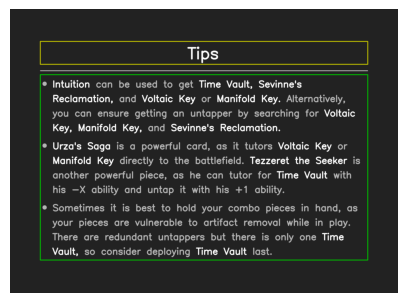

In [18]:
# Required Parameters - Back Image
image_back = images[0][0][1].copy()
text_boxes = images[0][1].copy()

# Back title text
cv2.rectangle(image_back,
              (350, 375),
              (image_back.shape[1] - 350,
               425 + text_boxes[5].bounding_box[1]),
              (192, 192, 0), 10);

# Back body text
cv2.rectangle(image_back,
              (350, 375 + 35 + text_boxes[5].line_height + text_boxes[5].bounding_box[1]),
              (image_back.shape[1] - 350,
               425 + 35 + text_boxes[5].line_height + text_boxes[5].bounding_box[1] + text_boxes[6].bounding_box[1]),
              (0, 192, 0), 10);

display_image(image_back)

# cv2.imwrite('instructional-images/required_parameters_back.png',
#             cv2.cvtColor(image_back, cv2.COLOR_BGR2RGB))

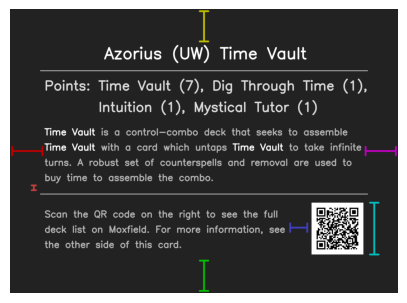

In [19]:
# Optional Parameters - Margins, QR, Offsets, and Line Spacing
image_front = images[0][0][0].copy()
text_boxes = images[0][1].copy()

# QR Size
place_line(image_front,
           image_front.shape[1] - 275,
           image_front.shape[1] - 275,
           400 + 70 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
           + text_boxes[2].line_height + text_boxes[2].bounding_box[1]\
           + text_boxes[3].line_height + text_boxes[3].bounding_box[1]\
           + 700,
           400 + 70 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
           + text_boxes[2].line_height + text_boxes[2].bounding_box[1]\
           + text_boxes[3].line_height + text_boxes[3].bounding_box[1]\
           + 700 - 600,
           color = (0, 192, 192), line_width = 20)
place_line(image_front,
           image_front.shape[1] - 225,
           image_front.shape[1] - 325,
           400 + 70 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
           + text_boxes[2].line_height + text_boxes[2].bounding_box[1]\
           + text_boxes[3].line_height + text_boxes[3].bounding_box[1]\
           + 700 - 600,
           400 + 70 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
           + text_boxes[2].line_height + text_boxes[2].bounding_box[1]\
           + text_boxes[3].line_height + text_boxes[3].bounding_box[1]\
           + 700 - 600,
           color = (0, 192, 192), line_width = 20)
place_line(image_front,
           image_front.shape[1] - 225,
           image_front.shape[1] - 325,
           400 + 70 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
           + text_boxes[2].line_height + text_boxes[2].bounding_box[1]\
           + text_boxes[3].line_height + text_boxes[3].bounding_box[1]\
           + 700,
           400 + 70 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
           + text_boxes[2].line_height + text_boxes[2].bounding_box[1]\
           + text_boxes[3].line_height + text_boxes[3].bounding_box[1]\
           + 700,
           color = (0, 192, 192), line_width = 20)

# QR Offset
place_line(image_front,
           425 + text_boxes[4].bounding_box[0],
           image_front.shape[1] - 400 - 650,
           425 + 70 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
           + text_boxes[2].line_height + text_boxes[2].bounding_box[1]\
           + text_boxes[3].line_height + text_boxes[3].bounding_box[1]\
           + 700 - int(text_boxes[4].bounding_box[1] / 2) - text_boxes[4].line_height,
           425 + 70 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
           + text_boxes[2].line_height + text_boxes[2].bounding_box[1]\
           + text_boxes[3].line_height + text_boxes[3].bounding_box[1]\
           + 700 - int(text_boxes[4].bounding_box[1] / 2) - text_boxes[4].line_height,
           color = (64, 64, 192), line_width = 20)
place_line(image_front,
           425 + text_boxes[4].bounding_box[0],
           425 + text_boxes[4].bounding_box[0],
           425 + 70 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
           + text_boxes[2].line_height + text_boxes[2].bounding_box[1]\
           + text_boxes[3].line_height + text_boxes[3].bounding_box[1]\
           + 700 - int(text_boxes[4].bounding_box[1] / 2) - text_boxes[4].line_height - 50,
           425 + 70 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
           + text_boxes[2].line_height + text_boxes[2].bounding_box[1]\
           + text_boxes[3].line_height + text_boxes[3].bounding_box[1]\
           + 700 - int(text_boxes[4].bounding_box[1] / 2) - text_boxes[4].line_height + 50,
           color = (64, 64, 192), line_width = 20)
place_line(image_front,
           image_front.shape[1] - 400 - 650,
           image_front.shape[1] - 400 - 650,
           425 + 70 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
           + text_boxes[2].line_height + text_boxes[2].bounding_box[1]\
           + text_boxes[3].line_height + text_boxes[3].bounding_box[1]\
           + 700 - int(text_boxes[4].bounding_box[1] / 2) - text_boxes[4].line_height - 50,
           425 + 70 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
           + text_boxes[2].line_height + text_boxes[2].bounding_box[1]\
           + text_boxes[3].line_height + text_boxes[3].bounding_box[1]\
           + 700 - int(text_boxes[4].bounding_box[1] / 2) - text_boxes[4].line_height + 50,
           color = (64, 64, 192), line_width = 20)

# Left margin
place_line(image_front,
           25,
           375,
           int(image_front.shape[0] / 2),
           int(image_front.shape[0] / 2),
           color = (192, 0, 0), line_width = 20)
place_line(image_front,
           25,
           25,
           int(image_front.shape[0] / 2) - 50,
           int(image_front.shape[0] / 2 + 50),
           color = (192, 0, 0), line_width = 20)
place_line(image_front,
           375,
           375,
           int(image_front.shape[0] / 2) - 50,
           int(image_front.shape[0] / 2 + 50),
           color = (192, 0, 0), line_width = 20)

# Right margin
place_line(image_front,
           image_front.shape[1] - 25,
           image_front.shape[1] - 375,
           int(image_front.shape[0] / 2),
           int(image_front.shape[0] / 2),
           color = (192, 0, 192), line_width = 20)
place_line(image_front,
           image_front.shape[1] - 25,
           image_front.shape[1] - 25,
           int(image_front.shape[0] / 2) - 50,
           int(image_front.shape[0] / 2 + 50),
           color = (192, 0, 192), line_width = 20)
place_line(image_front,
           image_front.shape[1] - 375,
           image_front.shape[1] - 375,
           int(image_front.shape[0] / 2) - 50,
           int(image_front.shape[0] / 2 + 50),
           color = (192, 0, 192), line_width = 20)

# Top margin
place_line(image_front,
           int(image_front.shape[1] / 2),
           int(image_front.shape[1] / 2),
           25,
           375,
           color = (192, 192, 0), line_width = 20)
place_line(image_front,
           int(image_front.shape[1] / 2) - 50,
           int(image_front.shape[1] / 2) + 50,
           25,
           25,
           color = (192, 192, 0), line_width = 20)
place_line(image_front,
           int(image_front.shape[1] / 2) - 50,
           int(image_front.shape[1] / 2) + 50,
           375,
           375,
           color = (192, 192, 0), line_width = 20)

# Bot margin
place_line(image_front,
           int(image_front.shape[1] / 2),
           int(image_front.shape[1] / 2),
           image_front.shape[0] - 25,
           image_front.shape[0] - 375,
           color = (0, 192, 0), line_width = 20)
place_line(image_front,
           int(image_front.shape[1] / 2) - 50,
           int(image_front.shape[1] / 2) + 50,
           image_front.shape[0] - 25,
           image_front.shape[0] - 25,
           color = (0, 192, 0), line_width = 20)
place_line(image_front,
           int(image_front.shape[1] / 2) - 50,
           int(image_front.shape[1] / 2) + 50,
           image_front.shape[0] - 375,
           image_front.shape[0] - 375,
           color = (0, 192, 0), line_width = 20)

# Line break spacing
place_line(image_front,
           275,
           275,
           425 + 25 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
           + text_boxes[2].line_height + text_boxes[2].bounding_box[1] + text_boxes[3].bounding_box[1],
           425 + 80 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
           + text_boxes[2].line_height + text_boxes[2].bounding_box[1] + text_boxes[3].bounding_box[1],
           color = (192, 64, 64), line_width = 20)
place_line(image_front,
           250,
           300,
           425 + 25 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
           + text_boxes[2].line_height + text_boxes[2].bounding_box[1] + text_boxes[3].bounding_box[1],
           425 + 25 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
           + text_boxes[2].line_height + text_boxes[2].bounding_box[1] + text_boxes[3].bounding_box[1],
           color = (192, 64, 64), line_width = 20)
place_line(image_front,
           250,
           300,
           425 + 80 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
           + text_boxes[2].line_height + text_boxes[2].bounding_box[1] + text_boxes[3].bounding_box[1],
           425 + 80 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
           + text_boxes[2].line_height + text_boxes[2].bounding_box[1] + text_boxes[3].bounding_box[1],
           color = (192, 64, 64), line_width = 20)

display_image(image_front)

# cv2.imwrite('instructional-images/optional_parameters_offsets.png',
#             cv2.cvtColor(image_front, cv2.COLOR_BGR2RGB))

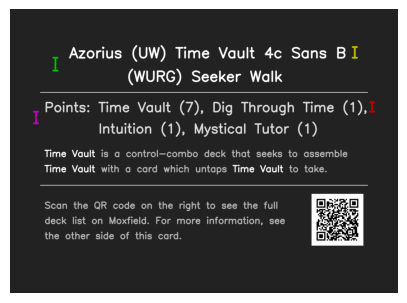

In [20]:
# Optional Parameters - Margins, QR, Offsets, and Line Spacing
image_front = images[3][0][0].copy()
text_boxes = images[3][1].copy()

# Title font scale
place_line(image_front,
           image_front.shape[1] - 500,
           image_front.shape[1] - 500,
           400 + int((text_boxes[0].bounding_box[1] - text_boxes[0].height) / 2),
           400 + int((text_boxes[0].bounding_box[1] - text_boxes[0].height) / 2) + text_boxes[0].line_height,
           color = (192, 192, 0), line_width = 20)
place_line(image_front,
           image_front.shape[1] - 475,
           image_front.shape[1] - 525,
           400 + int((text_boxes[0].bounding_box[1] - text_boxes[0].height) / 2),
           400 + int((text_boxes[0].bounding_box[1] - text_boxes[0].height) / 2),
           color = (192, 192, 0), line_width = 20)
place_line(image_front,
           image_front.shape[1] - 475,
           image_front.shape[1] - 525,
           400 + int((text_boxes[0].bounding_box[1] - text_boxes[0].height) / 2) + text_boxes[0].line_height,
           400 + int((text_boxes[0].bounding_box[1] - text_boxes[0].height) / 2) + text_boxes[0].line_height,
           color = (192, 192, 0), line_width = 20)

# Title line spacing
place_line(image_front,
           525,
           525,
           400 + int((text_boxes[0].bounding_box[1] - text_boxes[0].height) / 2) + text_boxes[0].line_height,
           400 + int((text_boxes[0].bounding_box[1] - text_boxes[0].height) / 2) + text_boxes[0].line_height\
           + int(text_boxes[0].line_spacing * text_boxes[0].line_height),
           color = (0, 192, 0), line_width = 20)
place_line(image_front,
           500,
           550,
           400 + int((text_boxes[0].bounding_box[1] - text_boxes[0].height) / 2) + text_boxes[0].line_height,
           400 + int((text_boxes[0].bounding_box[1] - text_boxes[0].height) / 2) + text_boxes[0].line_height,
           color = (0, 192, 0), line_width = 20)
place_line(image_front,
           500,
           550,
           400 + int((text_boxes[0].bounding_box[1] - text_boxes[0].height) / 2) + text_boxes[0].line_height\
           + int(text_boxes[0].line_spacing * text_boxes[0].line_height),
           400 + int((text_boxes[0].bounding_box[1] - text_boxes[0].height) / 2) + text_boxes[0].line_height\
           + int(text_boxes[0].line_spacing * text_boxes[0].line_height),
           color = (0, 192, 0), line_width = 20)

# Points font scale
place_line(image_front,
           image_front.shape[1] - 300,
           image_front.shape[1] - 300,
           400 + 35 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
           + int((text_boxes[2].bounding_box[1] - text_boxes[2].height) / 2),
           400 + 35 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
           + int((text_boxes[2].bounding_box[1] - text_boxes[2].height) / 2) + text_boxes[2].line_height,
           color = (192, 0, 0), line_width = 20)
place_line(image_front,
           image_front.shape[1] - 275,
           image_front.shape[1] - 325,
           400 + 35 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
           + int((text_boxes[2].bounding_box[1] - text_boxes[2].height) / 2),
           400 + 35 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
           + int((text_boxes[2].bounding_box[1] - text_boxes[2].height) / 2),
           color = (192, 0, 0), line_width = 20)
place_line(image_front,
           image_front.shape[1] - 275,
           image_front.shape[1] - 325,
           400 + 35 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
           + int((text_boxes[2].bounding_box[1] - text_boxes[2].height) / 2) + text_boxes[2].line_height,
           400 + 35 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
           + int((text_boxes[2].bounding_box[1] - text_boxes[2].height) / 2) + text_boxes[2].line_height,
           color = (192, 0, 0), line_width = 20)

# Points line spacing
place_line(image_front,
           300,
           300,
           400 + 35 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
           + int((text_boxes[2].bounding_box[1] - text_boxes[2].height) / 2) + text_boxes[2].line_height,
           400 + 35 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
           + int((text_boxes[2].bounding_box[1] - text_boxes[2].height) / 2) + text_boxes[2].line_height\
           + int(text_boxes[2].line_spacing * text_boxes[2].line_height),
           color = (192, 0, 192), line_width = 20)
place_line(image_front,
           275,
           325,
           400 + 35 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
           + int((text_boxes[2].bounding_box[1] - text_boxes[2].height) / 2) + text_boxes[2].line_height,
           400 + 35 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
           + int((text_boxes[2].bounding_box[1] - text_boxes[2].height) / 2) + text_boxes[2].line_height,
           color = (192, 0, 192), line_width = 20)
place_line(image_front,
           275,
           325,
           400 + 35 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
           + int((text_boxes[2].bounding_box[1] - text_boxes[2].height) / 2) + text_boxes[2].line_height\
           + int(text_boxes[2].line_spacing * text_boxes[2].line_height),
           400 + 35 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
           + int((text_boxes[2].bounding_box[1] - text_boxes[2].height) / 2) + text_boxes[2].line_height\
           + int(text_boxes[2].line_spacing * text_boxes[2].line_height),
           color = (192, 0, 192), line_width = 20)

display_image(image_front)

# cv2.imwrite('instructional-images/optional_parameters_title_and_points.png',
#             cv2.cvtColor(image_front, cv2.COLOR_BGR2RGB))

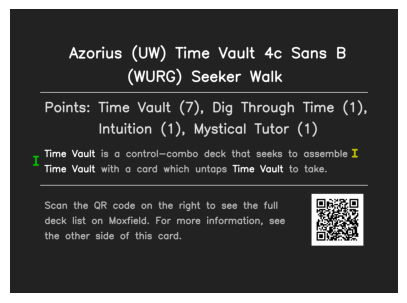

In [21]:
# Optional Parameters - Summary Text
image_front = images[3][0][0].copy()
text_boxes = images[3][1].copy()

# Summary font scale
place_line(image_front,
           image_front.shape[1] - 500,
           image_front.shape[1] - 500,
           400 + 35 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
           + text_boxes[2].line_height + text_boxes[2].bounding_box[1]\
           + int((text_boxes[3].bounding_box[1] - text_boxes[3].height) / 2),
           400 + 35 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
           + text_boxes[2].line_height + text_boxes[2].bounding_box[1]\
           + int((text_boxes[3].bounding_box[1] - text_boxes[3].height) / 2) + text_boxes[3].line_height,
           color = (192, 192, 0), line_width = 20)
place_line(image_front,
           image_front.shape[1] - 475,
           image_front.shape[1] - 525,
           400 + 35 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
           + text_boxes[2].line_height + text_boxes[2].bounding_box[1]\
           + int((text_boxes[3].bounding_box[1] - text_boxes[3].height) / 2),
           400 + 35 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
           + text_boxes[2].line_height + text_boxes[2].bounding_box[1]\
           + int((text_boxes[3].bounding_box[1] - text_boxes[3].height) / 2),
           color = (192, 192, 0), line_width = 20)
place_line(image_front,
           image_front.shape[1] - 475,
           image_front.shape[1] - 525,
           400 + 35 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
           + text_boxes[2].line_height + text_boxes[2].bounding_box[1]\
           + int((text_boxes[3].bounding_box[1] - text_boxes[3].height) / 2) + text_boxes[3].line_height,
           400 + 35 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
           + text_boxes[2].line_height + text_boxes[2].bounding_box[1]\
           + int((text_boxes[3].bounding_box[1] - text_boxes[3].height) / 2) + text_boxes[3].line_height,
           color = (192, 192, 0), line_width = 20)

# Summary line spacing
place_line(image_front,
           300,
           300,
           400 + 35 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
           + text_boxes[2].line_height + text_boxes[2].bounding_box[1]\
           + int((text_boxes[3].bounding_box[1] - text_boxes[3].height) / 2) + text_boxes[3].line_height,
           400 + 35 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
           + text_boxes[2].line_height + text_boxes[2].bounding_box[1]\
           + int((text_boxes[3].bounding_box[1] - text_boxes[3].height) / 2) + text_boxes[3].line_height\
           + int(text_boxes[3].line_spacing * text_boxes[3].line_height),
           color = (0, 192, 0), line_width = 20)
place_line(image_front,
           275,
           325,
           400 + 35 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
           + text_boxes[2].line_height + text_boxes[2].bounding_box[1]\
           + int((text_boxes[3].bounding_box[1] - text_boxes[3].height) / 2) + text_boxes[3].line_height,
           400 + 35 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
           + text_boxes[2].line_height + text_boxes[2].bounding_box[1]\
           + int((text_boxes[3].bounding_box[1] - text_boxes[3].height) / 2) + text_boxes[3].line_height,
           color = (0, 192, 0), line_width = 20)
place_line(image_front,
           275,
           325,
           400 + 35 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
           + text_boxes[2].line_height + text_boxes[2].bounding_box[1]\
           + int((text_boxes[3].bounding_box[1] - text_boxes[3].height) / 2) + text_boxes[3].line_height\
           + int(text_boxes[3].line_spacing * text_boxes[3].line_height),
           400 + 35 + text_boxes[0].line_height + text_boxes[0].bounding_box[1]\
           + text_boxes[2].line_height + text_boxes[2].bounding_box[1]\
           + int((text_boxes[3].bounding_box[1] - text_boxes[3].height) / 2) + text_boxes[3].line_height\
           + int(text_boxes[3].line_spacing * text_boxes[3].line_height),
           color = (0, 192, 0), line_width = 20)

display_image(image_front)

# cv2.imwrite('instructional-images/optional_parameters_summary.png',
#             cv2.cvtColor(image_front, cv2.COLOR_BGR2RGB))

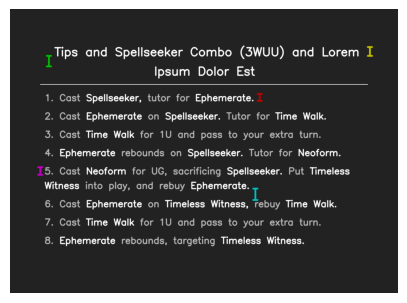

In [38]:
# Optional Parameters - Back Text, Paragraphs, and Bullet Points
image_back = images[3][0][1].copy()
text_boxes = images[3][1].copy()

# Back title font scale
place_line(image_back,
           image_back.shape[1] - 325,
           image_back.shape[1] - 325,
           400 + int((text_boxes[5].bounding_box[1] - text_boxes[5].height) / 2),
           400 + int((text_boxes[5].bounding_box[1] - text_boxes[5].height) / 2) + text_boxes[5].line_height,
           color = (192, 192, 0), line_width = 20)
place_line(image_back,
           image_back.shape[1] - 300,
           image_back.shape[1] - 350,
           400 + int((text_boxes[5].bounding_box[1] - text_boxes[5].height) / 2),
           400 + int((text_boxes[5].bounding_box[1] - text_boxes[5].height) / 2),
           color = (192, 192, 0), line_width = 20)
place_line(image_back,
           image_back.shape[1] - 300,
           image_back.shape[1] - 350,
           400 + int((text_boxes[5].bounding_box[1] - text_boxes[5].height) / 2) + text_boxes[5].line_height,
           400 + int((text_boxes[5].bounding_box[1] - text_boxes[5].height) / 2) + text_boxes[5].line_height,
           color = (192, 192, 0), line_width = 20)

# Back title line spacing
place_line(image_back,
           450,
           450,
           400 + int((text_boxes[5].bounding_box[1] - text_boxes[5].height) / 2) + text_boxes[5].line_height,
           400 + int((text_boxes[5].bounding_box[1] - text_boxes[5].height) / 2) + text_boxes[5].line_height\
           + int((text_boxes[5].line_spacing) * text_boxes[5].line_height),
           color = (0, 192, 0), line_width = 20)
place_line(image_back,
           425,
           475,
           400 + int((text_boxes[5].bounding_box[1] - text_boxes[5].height) / 2) + text_boxes[5].line_height,
           400 + int((text_boxes[5].bounding_box[1] - text_boxes[5].height) / 2) + text_boxes[5].line_height,
           color = (0, 192, 0), line_width = 20)
place_line(image_back,
           425,
           475,
           400 + int((text_boxes[5].bounding_box[1] - text_boxes[5].height) / 2) + text_boxes[5].line_height\
           + int((text_boxes[5].line_spacing) * text_boxes[5].line_height),
           400 + int((text_boxes[5].bounding_box[1] - text_boxes[5].height) / 2) + text_boxes[5].line_height\
           + int((text_boxes[5].line_spacing) * text_boxes[5].line_height),
           color = (0, 192, 0), line_width = 20)

# Back body font scale
place_line(image_back,
           image_back.shape[1] - 1600,
           image_back.shape[1] - 1600,
           400 + 35 + text_boxes[5].line_height + text_boxes[5].bounding_box[1]\
           + int((text_boxes[6].bounding_box[1] - text_boxes[6].height) / 2),
           400 + 35 + text_boxes[5].line_height + text_boxes[5].bounding_box[1]\
           + int((text_boxes[6].bounding_box[1] - text_boxes[6].height) / 2) + text_boxes[6].line_height,
           color = (192, 0, 0), line_width = 20)
place_line(image_back,
           image_back.shape[1] - 1575,
           image_back.shape[1] - 1625,
           400 + 35 + text_boxes[5].line_height + text_boxes[5].bounding_box[1]\
           + int((text_boxes[6].bounding_box[1] - text_boxes[6].height) / 2),
           400 + 35 + text_boxes[5].line_height + text_boxes[5].bounding_box[1]\
           + int((text_boxes[6].bounding_box[1] - text_boxes[6].height) / 2),
           color = (192, 0, 0), line_width = 20)
place_line(image_back,
           image_back.shape[1] - 1575,
           image_back.shape[1] - 1625,
           400 + 35 + text_boxes[5].line_height + text_boxes[5].bounding_box[1]\
           + int((text_boxes[6].bounding_box[1] - text_boxes[6].height) / 2) + text_boxes[6].line_height,
           400 + 35 + text_boxes[5].line_height + text_boxes[5].bounding_box[1]\
           + int((text_boxes[6].bounding_box[1] - text_boxes[6].height) / 2) + text_boxes[6].line_height,
           color = (192, 0, 0), line_width = 20)

# Back body line spacing
place_line(image_back,
           350,
           350,
           400 + 35 + text_boxes[5].line_height + text_boxes[5].bounding_box[1]\
           + int((text_boxes[6].bounding_box[1] - text_boxes[6].height) / 2) + int(4 * text_boxes[6].line_height)\
           + int(6 * text_boxes[6].line_spacing * text_boxes[6].line_height),
           400 + 35 + text_boxes[5].line_height + text_boxes[5].bounding_box[1]\
           + int((text_boxes[6].bounding_box[1] - text_boxes[6].height) / 2) + int(4 * text_boxes[6].line_height)\
           + int(7 * text_boxes[6].line_spacing * text_boxes[6].line_height),
           color = (192, 0, 192), line_width = 20)
place_line(image_back,
           325,
           375,
           400 + 35 + text_boxes[5].line_height + text_boxes[5].bounding_box[1]\
           + int((text_boxes[6].bounding_box[1] - text_boxes[6].height) / 2) + int(4 * text_boxes[6].line_height)\
           + int(6 * text_boxes[6].line_spacing * text_boxes[6].line_height),
           400 + 35 + text_boxes[5].line_height + text_boxes[5].bounding_box[1]\
           + int((text_boxes[6].bounding_box[1] - text_boxes[6].height) / 2) + int(4 * text_boxes[6].line_height)\
           + int(6 * text_boxes[6].line_spacing * text_boxes[6].line_height),
           color = (192, 0, 192), line_width = 20)
place_line(image_back,
           325,
           375,
           400 + 35 + text_boxes[5].line_height + text_boxes[5].bounding_box[1]\
           + int((text_boxes[6].bounding_box[1] - text_boxes[6].height) / 2) + int(4 * text_boxes[6].line_height)\
           + int(7 * text_boxes[6].line_spacing * text_boxes[6].line_height),
           400 + 35 + text_boxes[5].line_height + text_boxes[5].bounding_box[1]\
           + int((text_boxes[6].bounding_box[1] - text_boxes[6].height) / 2) + int(4 * text_boxes[6].line_height)\
           + int(7 * text_boxes[6].line_spacing * text_boxes[6].line_height),
           color = (192, 0, 192), line_width = 20)

# Paragraph spacing
place_line(image_back,
           image_back.shape[1] - 1650,
           image_back.shape[1] - 1650,
           400 + 35 + text_boxes[5].line_height + text_boxes[5].bounding_box[1]\
           + int((text_boxes[6].bounding_box[1] - text_boxes[6].height) / 2) + int(6 * text_boxes[6].line_height)\
           + int(7 * text_boxes[6].line_spacing * text_boxes[6].line_height),
           400 + 35 + text_boxes[5].line_height + text_boxes[5].bounding_box[1]\
           + int((text_boxes[6].bounding_box[1] - text_boxes[6].height) / 2) + int(6 * text_boxes[6].line_height)\
           + int(8.5 * text_boxes[6].line_spacing * text_boxes[6].line_height),
           color = (0, 192, 192), line_width = 20)
place_line(image_back,
           image_back.shape[1] - 1625,
           image_back.shape[1] - 1675,
           400 + 35 + text_boxes[5].line_height + text_boxes[5].bounding_box[1]\
           + int((text_boxes[6].bounding_box[1] - text_boxes[6].height) / 2) + int(6 * text_boxes[6].line_height)\
           + int(7 * text_boxes[6].line_spacing * text_boxes[6].line_height),
           400 + 35 + text_boxes[5].line_height + text_boxes[5].bounding_box[1]\
           + int((text_boxes[6].bounding_box[1] - text_boxes[6].height) / 2) + int(6 * text_boxes[6].line_height)\
           + int(7 * text_boxes[6].line_spacing * text_boxes[6].line_height),
           color = (0, 192, 192), line_width = 20)
place_line(image_back,
           image_back.shape[1] - 1625,
           image_back.shape[1] - 1675,
           400 + 35 + text_boxes[5].line_height + text_boxes[5].bounding_box[1]\
           + int((text_boxes[6].bounding_box[1] - text_boxes[6].height) / 2) + int(6 * text_boxes[6].line_height)\
           + int(8.5 * text_boxes[6].line_spacing * text_boxes[6].line_height),
           400 + 35 + text_boxes[5].line_height + text_boxes[5].bounding_box[1]\
           + int((text_boxes[6].bounding_box[1] - text_boxes[6].height) / 2) + int(6 * text_boxes[6].line_height)\
           + int(8.5 * text_boxes[6].line_spacing * text_boxes[6].line_height),
           color = (0, 192, 192), line_width = 20)

display_image(image_back)

# cv2.imwrite('instructional-images/optional_parameters_back_text_and_paragraphs.png',
#             cv2.cvtColor(image_back, cv2.COLOR_BGR2RGB))